In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

c:\Users\ing_c\miniconda3\envs\ai-gpu\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
datos, metadatos = tfds.load("mnist", as_supervised=True, with_info=True)

In [4]:
metadatos

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='C:\\Users\\ing_c\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={

In [5]:
datos_entrenamiento = datos["train"]
datos_pruebas = datos["test"]

In [6]:
nombres_clases = metadatos.features["label"].names

In [7]:
#Normalizacion
#0-255 1 byte
#Transformar 0-255 0-1 (0=0, 255=1, 127=.5)

#Normalizar datos ent y pruebas con una funcion
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes = imagenes/255
  return imagenes, etiquetas

datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregar en cache
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

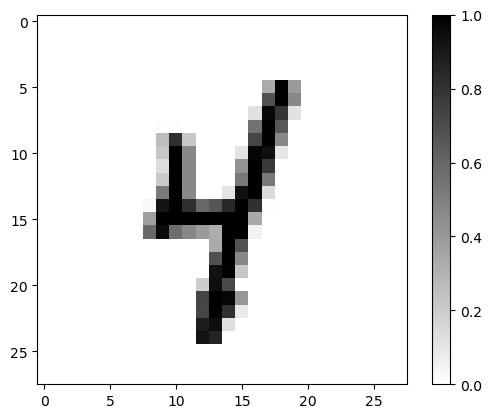

In [8]:
for imagen, etiqueta in datos_entrenamiento.take(1):
  break

import matplotlib.pyplot as plt

#Mostrarlo en pantalla
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

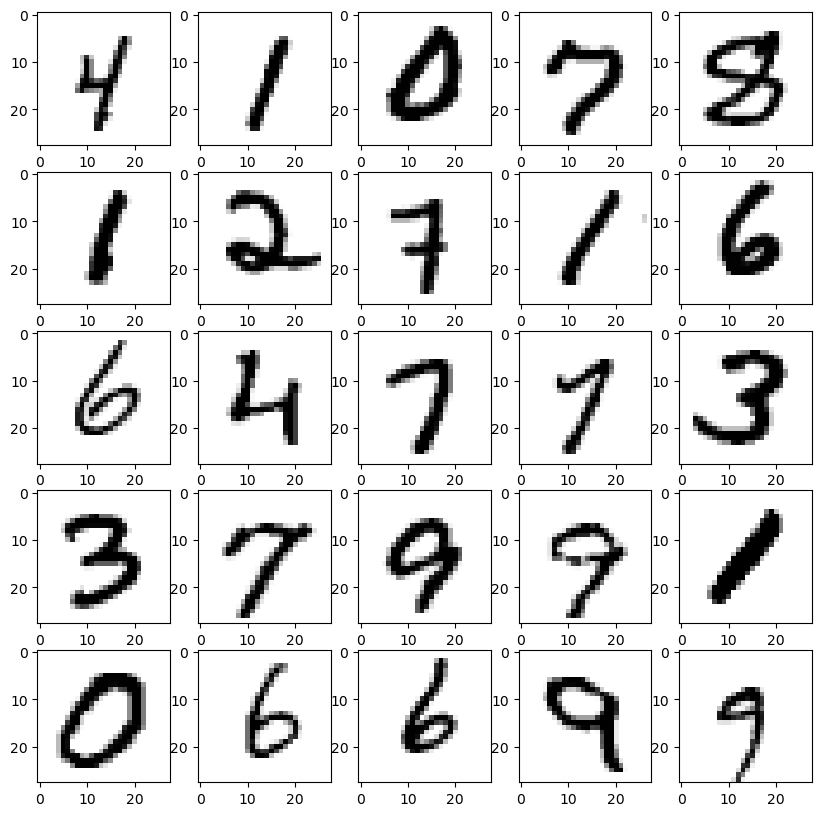

In [9]:
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  #Mostrarlo en pantalla
  plt.subplot(5, 5, i+1)
  plt.imshow(imagen, cmap=plt.cm.binary)

plt.show()

In [10]:
"""modelo = tf.keras.Sequential([
    #784 datos de entrada
    tf.keras.layers.Flatten(input_shape=(28,28,1)), #1 = blanco y negro
    # # # Capa oculta
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    # Capa de salida
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])"""

modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(28,28,1), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [11]:
modelo.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [12]:
TAMANO_LOTE = 32

datos_entrenamiento = datos_entrenamiento.repeat().shuffle(60000).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [13]:
import math

#Entrenar
entrnamiento = modelo.fit(
    datos_entrenamiento, epochs=10,
    steps_per_epoch=math.ceil(60000/TAMANO_LOTE)
)

Epoch 1/10



1875/1875 [==============================] - 11s 5ms/step - loss: 0.1326 - accuracy: 0.9590
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0417 - accuracy: 0.9869
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0287 - accuracy: 0.9909
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0192 - accuracy: 0.9937
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0171 - accuracy: 0.9948
Epoch 6/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0128 - accuracy: 0.9962
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0104 - accuracy: 0.9966
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0087 - accuracy: 0.9971
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0078 - accuracy: 0.9973
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0056 -

1/1 [==============================] - 0s 96ms/step


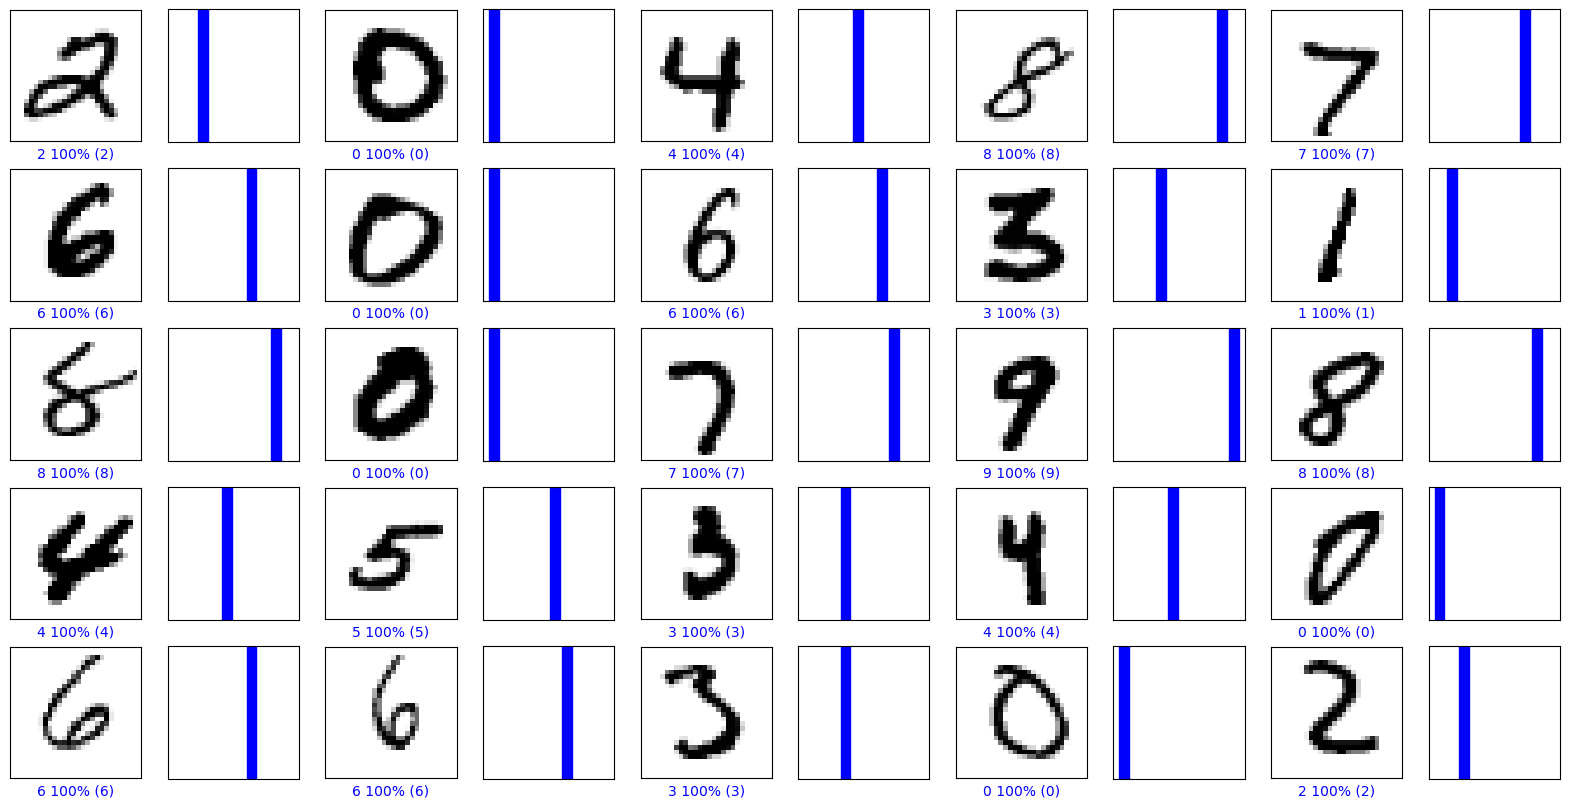

In [14]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

⚠️ ZIP ya existe, se omite descarga.
⚠️ Carpeta PetImages ya existe, se omite extracción.
🧹 Verificando imágenes...


c:\Users\ing_c\miniconda3\envs\ai-gpu\lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


✅ Limpieza lista. Archivos eliminados: 0
Found 24998 files belonging to 2 classes.
Using 19999 files for training.
✅ Dataset cargado con train/validation/test y metadatos listos


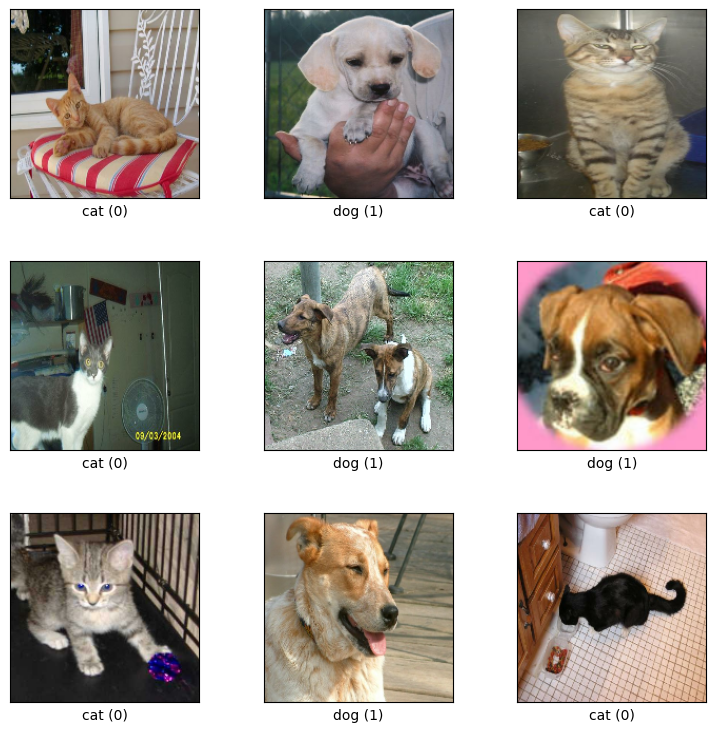

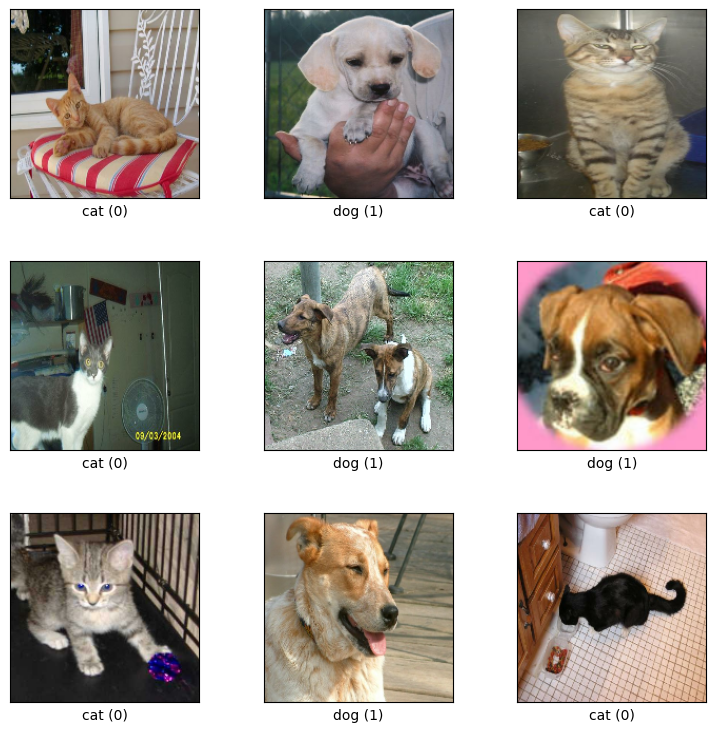

In [15]:
import os
import zipfile
import urllib.request
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds

# ==========================
# 1. CONFIGURACIÓN
# ==========================
URL = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
BASE_DIR = r"C:\datasets"
ZIP_PATH = os.path.join(BASE_DIR, "cats_vs_dogs_5340.zip")
EXTRACT_PATH = os.path.join(BASE_DIR, "cats_vs_dogs")
PETIMAGES_PATH = os.path.join(EXTRACT_PATH, "PetImages")

os.makedirs(BASE_DIR, exist_ok=True)

# ==========================
# 2. DESCARGA Y EXTRACCIÓN
# ==========================
if not os.path.exists(ZIP_PATH):
    print("⬇️ Descargando dataset...")
    urllib.request.urlretrieve(URL, ZIP_PATH)
    print("✅ Descarga completada.")
else:
    print("⚠️ ZIP ya existe, se omite descarga.")

if not os.path.exists(PETIMAGES_PATH):
    print("📂 Descomprimiendo...")
    with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("✅ Descompresión lista.")
else:
    print("⚠️ Carpeta PetImages ya existe, se omite extracción.")

# ==========================
# 3. LIMPIEZA DE ARCHIVOS CORRUPTOS
# ==========================
print("🧹 Verificando imágenes...")
bad_files = []
for root, _, files in os.walk(PETIMAGES_PATH):
    for f in files:
        path = os.path.join(root, f)
        try:
            img = Image.open(path)
            img.verify()
        except Exception:
            bad_files.append(path)
            try:
                os.remove(path)
            except:
                pass

print("✅ Limpieza lista. Archivos eliminados:", len(bad_files))

# ==========================
# 4. CREAR DATASETS
# ==========================
full_ds = tf.keras.utils.image_dataset_from_directory(
    PETIMAGES_PATH,
    image_size=(180, 180),
    batch_size=32,
    color_mode="rgb", # 👈 fuerza siempre 3 canales
    validation_split=0.2,
    subset="training",
    seed=123
)

# Normalización
normalization_layer = tf.keras.layers.Rescaling(1./255)
full_ds = full_ds.map(lambda x, y: (normalization_layer(x), y))

# Dividir en train/val/test (80/10/10)
dataset_size = 25000  # Total aprox de imágenes en PetImages
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)

train_ds = full_ds.take(train_size // 32)
val_ds = full_ds.skip(train_size // 32).take(val_size // 32)
test_ds = full_ds.skip((train_size + val_size) // 32)

# Empaquetar igual que tfds.load()
datos = {
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
}

# ==========================
# 5. METADATOS
# ==========================
class FakeBuilder(tfds.core.DatasetBuilder):
    VERSION = tfds.core.Version("1.0.0")

    def __init__(self):
        super().__init__(data_dir=None)

    def _info(self):
        return tfds.core.DatasetInfo(
            builder=self,
            description="Cats vs Dogs dataset (versión limpia, descargada de Microsoft).",
            features=tfds.features.FeaturesDict({
                "image": tfds.features.Image(shape=(180, 180, 3)),
                "label": tfds.features.ClassLabel(names=["cat", "dog"]),
            }),
            supervised_keys=("image", "label"),
        )

    def _download_and_prepare(self, dl_manager=None, download_config=None):
        return

    def _as_dataset(self, *args, **kwargs):
        return {}

fake_builder = FakeBuilder()
metadatos = fake_builder.info

print("✅ Dataset cargado con train/validation/test y metadatos listos")

# ==========================
# 6. VISUALIZAR EJEMPLOS
# ==========================
tfds.show_examples(datos["train"].unbatch(), metadatos)



In [16]:
# datos, metadatos = tfds.load("cats_vs_dogs", as_supervised=True, with_info=True)

In [17]:
metadatos

tfds.core.DatasetInfo(
    name='fake_builder',
    full_name='fake_builder/1.0.0',
    description="""
    Cats vs Dogs dataset (versión limpia, descargada de Microsoft).
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/fake_builder',
    data_dir='C:\\Users\\ing_c\\tensorflow_datasets\\fake_builder\\1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(180, 180, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
    },
    citation="""""",
)

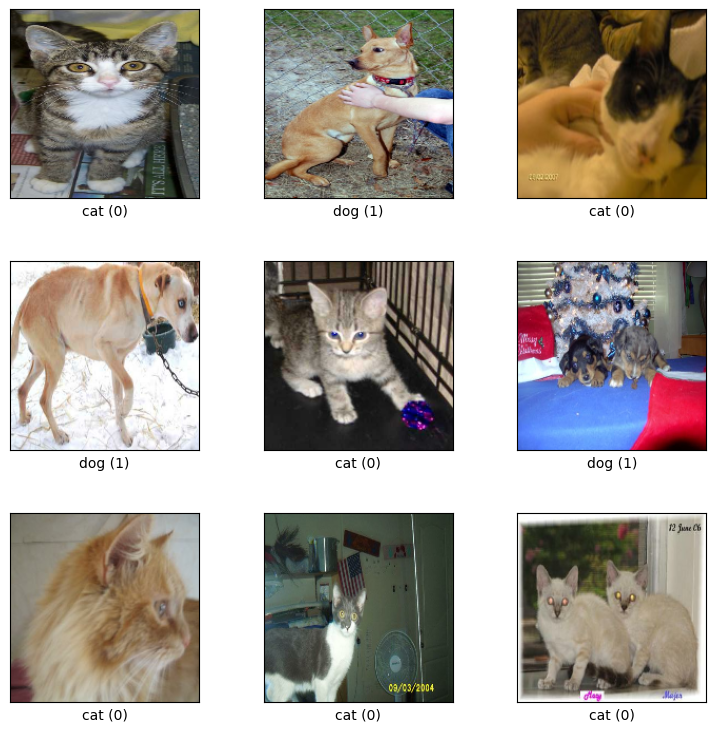

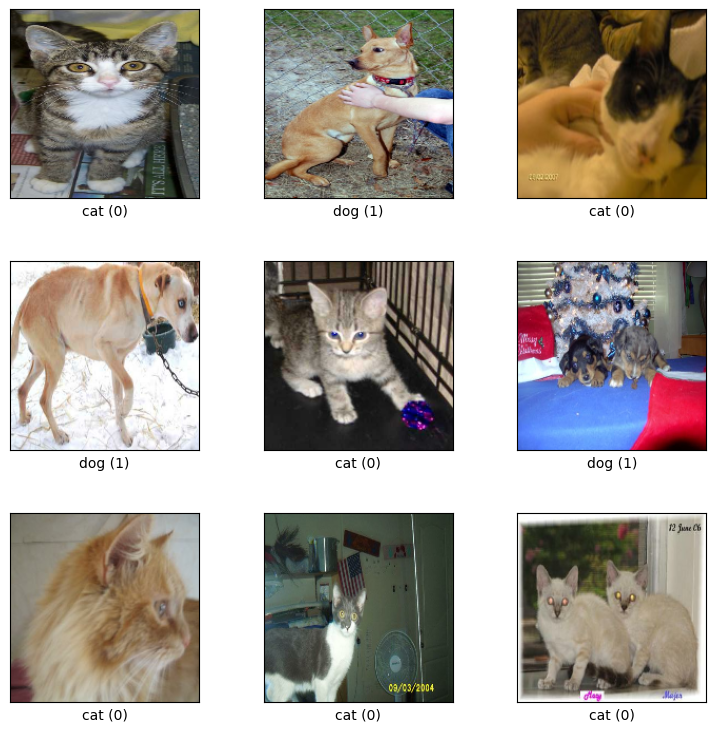

In [18]:
tfds.show_examples(datos["train"].unbatch(), metadatos)

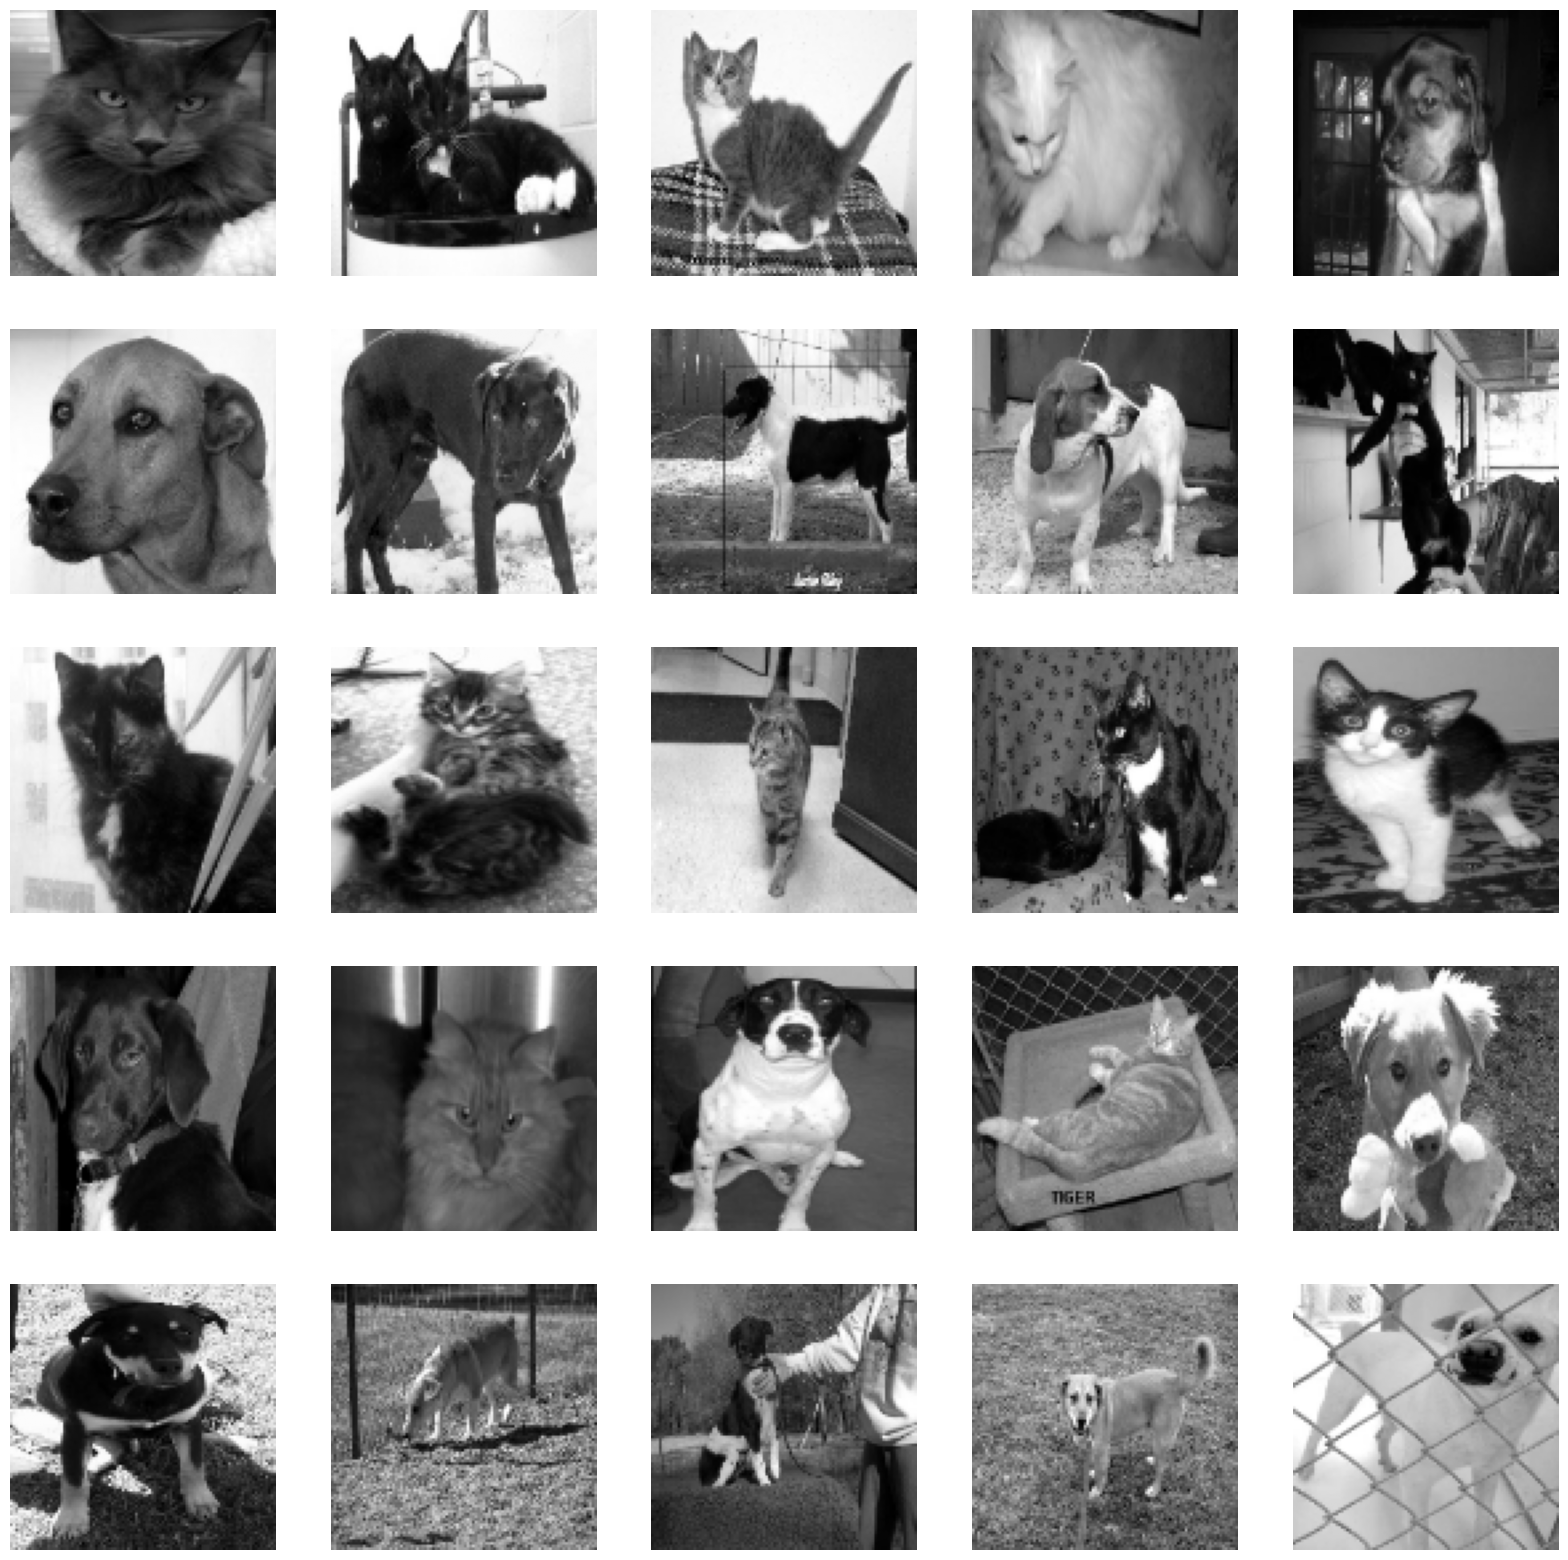

In [19]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

plt.figure(figsize=(20,20))
TAMANO_IMG = 100

for i, (imagen, etiqueta) in enumerate(datos["train"].unbatch().take(25)):
    img = imagen.numpy()

    # Redimensionar
    img = cv2.resize(img, (TAMANO_IMG, TAMANO_IMG))

    # Convertir a escala de grises
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    plt.subplot(5, 5, i+1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")

plt.show()


In [20]:
datos_entrenamiento = []

In [21]:
TAMANO_IMG = 100
datos_entrenamiento = []

for i, (imagen, etiqueta) in enumerate(
    datos["train"].unbatch().apply(tf.data.experimental.ignore_errors())
):
    img = tf.image.resize(imagen, [TAMANO_IMG, TAMANO_IMG])
    img = tf.image.rgb_to_grayscale(img)  # pasar a escala de grises
    datos_entrenamiento.append([img.numpy(), etiqueta.numpy()])


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [22]:
datos_entrenamiento[0]

[array([[[0.36905468],
         [0.31571358],
         [0.39183098],
         ...,
         [0.2112505 ],
         [0.36759198],
         [0.37522483]],
 
        [[0.26421574],
         [0.2648137 ],
         [0.28403237],
         ...,
         [0.5513803 ],
         [0.3610889 ],
         [0.39567515]],
 
        [[0.4403082 ],
         [0.33327964],
         [0.384353  ],
         ...,
         [0.4288588 ],
         [0.45833066],
         [0.37538314]],
 
        ...,
 
        [[0.15987056],
         [0.21518093],
         [0.29941848],
         ...,
         [0.30399594],
         [0.27672392],
         [0.24414109]],
 
        [[0.22576876],
         [0.281521  ],
         [0.38441664],
         ...,
         [0.35919702],
         [0.21208893],
         [0.2972976 ]],
 
        [[0.21242115],
         [0.36100066],
         [0.41298518],
         ...,
         [0.32981747],
         [0.33091432],
         [0.2489969 ]]], dtype=float32),
 1]

In [23]:
#Preparar variablas X y y

X = []
y = []

for imagen, etiqueta in datos_entrenamiento:
  X.append(imagen)
  y.append(etiqueta)

In [24]:
#Normalizar las imagenes
import numpy as np

X = np.array(X).astype(float) / 255

In [25]:
X[0]

array([[[0.00144727],
        [0.00123809],
        [0.00153659],
        ...,
        [0.00082843],
        [0.00144154],
        [0.00147147]],

       [[0.00103614],
        [0.00103849],
        [0.00111385],
        ...,
        [0.00216228],
        [0.00141603],
        [0.00155167]],

       [[0.0017267 ],
        [0.00130698],
        [0.00150727],
        ...,
        [0.0016818 ],
        [0.00179738],
        [0.00147209]],

       ...,

       [[0.00062694],
        [0.00084385],
        [0.00117419],
        ...,
        [0.00119214],
        [0.00108519],
        [0.00095742]],

       [[0.00088537],
        [0.001104  ],
        [0.00150752],
        ...,
        [0.00140862],
        [0.00083172],
        [0.00116587]],

       [[0.00083302],
        [0.00141569],
        [0.00161955],
        ...,
        [0.0012934 ],
        [0.0012977 ],
        [0.00097646]]])

In [26]:
y

[1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,


In [27]:
y = np.array(y)

In [28]:
modelo = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [29]:
modelo.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

In [30]:
modelo.fit(
    X, y, batch_size=32, validation_split=0.15, epochs=50
)

# Guardar modelo en formato .keras (recomendado desde TF 2.16)
modelo.save("modelo_clasificador_perros_gatos.keras")

# También puedes usar HDF5 (.h5) si prefieres
# modelo.save("modelo_clasificador.h5")

Epoch 1/50
529/529 [==============================] - 41s 76ms/step - loss: 0.6932 - accuracy: 0.4940 - val_loss: 0.6932 - val_accuracy: 0.4832
Epoch 2/50
529/529 [==============================] - 40s 75ms/step - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6931 - val_accuracy: 0.5168
Epoch 3/50
529/529 [==============================] - 39s 74ms/step - loss: 0.6932 - accuracy: 0.4935 - val_loss: 0.6931 - val_accuracy: 0.5168
Epoch 4/50
529/529 [==============================] - 38s 72ms/step - loss: 0.6932 - accuracy: 0.4947 - val_loss: 0.6931 - val_accuracy: 0.5168
Epoch 5/50
529/529 [==============================] - 38s 72ms/step - loss: 0.6932 - accuracy: 0.4954 - val_loss: 0.6930 - val_accuracy: 0.5168
Epoch 6/50
529/529 [==============================] - 38s 72ms/step - loss: 0.6932 - accuracy: 0.5033 - val_loss: 0.6934 - val_accuracy: 0.4832
Epoch 7/50
529/529 [==============================] - 38s 72ms/step - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6932 - val_accuracy:

In [1]:
#Sobreajuste over-fitting

#Dropout
#Aumento de datos